# 1. Looking back
I found the neural recordings data to be quite interesting. The real-time, nearly full spatial mapping of a brain region has fascinating implications for understanding nueral mechanisms and plasticity. 
I'm curious about what additional elements are needed for learning (e.g. whether reward is necessary). If nothing else is required perhaps the

The point to answer from the paper discussion is how the mechanistic learning could be seen in data. Once we've classified the neurons we can look at signal which spikes them. What happens when these signals are endlessly repeated? This could be as simple as going back into the data and finding the movie patterns which trigger a particular class. Does the signal repeat consistently?

# 2. Coarse-Graining

In [1]:
import sys, time, os
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2018)

### Create a simple dataset
Let's make a dataset which consists of two sets. I had some trouble understanding the point of this assignment, but here is what seems like a trivial data set. The first set has high expression of the first five species and the second set has high expression of the last five species.

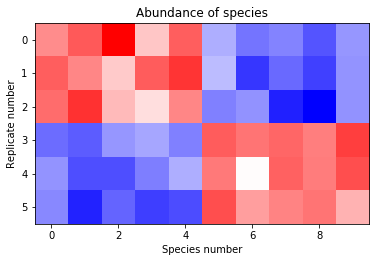

In [2]:
 ## create a dataset where the first half is big, and the second half is small
data = np.zeros((6,10))
sig = 0.4
big = 2
small= 0.2
for set_num in range(2):
    for rep_num in range(3):
        if set_num: 
            first = small; second = big
        else:
            first = big; second = small
        first_half  =  first + sig*np.random.randn(5)
        second_half = second + sig*np.random.randn(5)
        abundance = np.append(first_half,second_half)

        data[set_num*3 + rep_num] = abundance

## make a plot
plt.figure()
plt.imshow(data,cmap='bwr')
plt.xlabel("Species number")
plt.ylabel("Replicate number")
plt.title("Abundance of species")
plt.show()

### Coarse-graining option 1/2
One easy possibility for a coarse graining is the average of the first 5 species. Perhaps we believe these to be 'important' species, e.g. those which breaks down the original sugar.

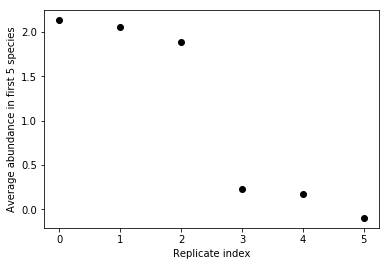

In [3]:
coarse_grain_1 = np.mean(data[:,:5],axis=1)
plt.plot(coarse_grain_1, 'ok')
plt.xlabel("Replicate index")
plt.ylabel("Average abundance in first 5 species");

### Coarse-graining option 2/2
The first strategy is a bit ad-hoc. Instead we can use distance to the first cluster.

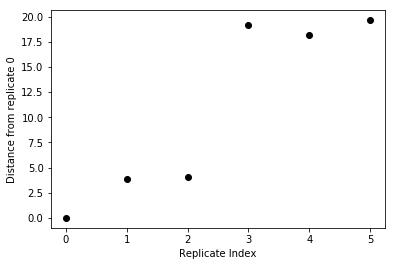

In [4]:
base = data[0]
coarse_grain_2 = np.zeros(6)
for i,abundance in enumerate(data):
    dist = sum(np.sqrt((base-abundance)**2))
    coarse_grain_2[i] = dist
plt.plot(coarse_grain_2, 'ok')
plt.xlabel("Replicate Index")
plt.ylabel("Distance from replicate 0");

### Bad coarse graining
Of course, it's easy to come up with a bad coarse graining via simply averaging over the "wrong set".

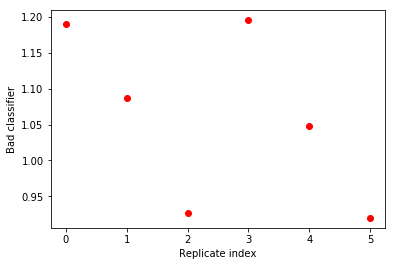

In [5]:
coarse_grain_3 = data.mean(axis=1)
plt.plot(coarse_grain_3, 'or')
plt.xlabel("Replicate index")
plt.ylabel("Bad classifier");

### Bad coarse graining 2/2
As in the previous case, we can turn a former good metric into a bad one by using the wrong reference state. In the next bad metric we compare each replicate to it's distance to the total average. As we have done in other analysis, perhaps we believe that we should compare to the mean population rather than to a null observation. 

Text(0,0.5,'Distance from global mean')

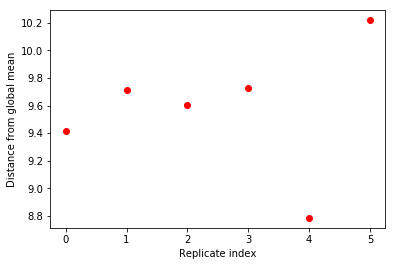

In [6]:
average_trial = np.mean(data,axis=0)

coarse_grain_4 = np.zeros(6)
for i,replicate in enumerate(data):
    dist = np.sum(np.sqrt((replicate-average_trial)**2))
    coarse_grain_4[i] = dist

plt.plot(coarse_grain_4,'or')
plt.xlabel("Replicate index")
plt.ylabel("Distance from global mean")

### Comparing coarse-graining with ANOVA
Given some method of coarse-graining into two bins, how can we clearly say whether they are different _enough_. Our default position should be that we don't know whether they are or not, and we consider how strongly our proposed metric distinguishes groups. We should quantify how "far away" the two groups are in units of the intrinsic spread of the dataset. This is exactly the idea of analysis of variance. It yields a statstic (an F-statistic) which quantifies how confidently we may reject the null hypothesis that there is no difference between our coarse-grained categories.

The strategy of ANOVA compares two variances. Variance, as always, is taken with respect to two means. ANOVA splits the variance into two comparison means. First is the variance of each proposed "treatments"- here the results of a coarse-graining- compared to the global, untreated mean. The second variance is every individual point to the global mean. The first variance can be thought of as signal, which is how far my categories are from 'null'. And the second is the background noise of uncategorized data. If the signal to noise ratio is high then the reduction is a legitimate one. More specifically, it is an instance of hypothesis testing. We are quantifying how strongly we reject the null hypothesis that there is no difference between sets.

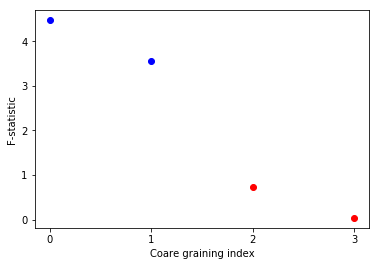

In [7]:
def oneWay_anova(data,verbose=False):
    ## calculate F-test by comparing Sum of Squares between group means
    ##      and between data points
    ## data: should be 2-D 
    num_groups = data.shape[0]
    num_repeats = data.shape[1]
   
    M = np.mean(data) 
  
    ## SS treatment: compare each group mean to global mean 
    diff = np.mean(data,axis=1) - M
    ss_treat = num_repeats*np.sum( diff**2 )
    ms_treat = ss_treat/(num_groups-1)

    ## SS err: compare all points to global mean
    all_dist = np.apply_along_axis(lambda x: x-np.mean(x),axis=1, arr=data)
    ss_err = np.sum( all_dist**2)
    ms_err = ss_err/( data.size-num_groups)

    #ss_tot = np.sum( (data-M)**2 )
    if verbose:
        print(ms_treat, ms_err)
        print(data)
        print(np.sum(data,axis=1))
        print(np.var(data,axis=1))
    return ms_treat/ms_err
##END oneWay_anova   


for i,array in enumerate([coarse_grain_1,coarse_grain_2,coarse_grain_3, coarse_grain_4]):
    array.shape = 3,2
    f_stat = oneWay_anova(array)
    c = 'bbrr'[i]
    plt.plot(i,f_stat, 'o', color=c)
plt.xlabel("Coare graining index")
plt.ylabel("F-statistic")
plt.xticks([0,1,2,3]);


One particular strength is that this statistic extends to any number of categores. One simply sums the variance across all the different categories and compares to the same global variation.

Even nonlinear relationships within data such as correlations in a thin shell seem to be captured by this metric. However, the "resolution" is lower because the treatments are not so distinct.   

Adding rare species to the dataset would increase the intrinsic variance and the assigned gropu variance. As such, rare species would tend to wash out the otherwise clear separation. Averaging over the rare finds could eliminate this 'problem', however, it is not clear to me what to make of rarely occuring species. Should these rare species be taken seriously or not (biologically and/or by the metric)?